In [11]:
%pip install opencv-contrib-python

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 68.7 MB 79.2 MB/s eta 0:00:01
  distutils: /zhome/99/e/203497/.local/lib/python3.9/site-packages
  sysconfig: /zhome/99/e/203497/.local/lib64/python3.9/site-packages
  user = True
  home = None
  root = None
  prefix = None
Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random

##  Visualize examples with the gt bounding boxes

In [36]:
# Directory path for the annotations
data_dir = "02516_poster_3/Potholes/annotated-images"

def parse_ground_truth_boxes(data_dir):
    """
    Parse XML annotation files to create ground truth boxes for each image.
    """
    ground_truth_boxes = {}

    for xml_file in os.listdir(data_dir):
        if xml_file.endswith(".xml"):
            # Parse the XML file
            xml_path = os.path.join(data_dir, xml_file)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            # Get image filename
            filename = root.find("filename").text
            
            # Extract bounding boxes
            boxes = []
            for obj in root.findall("object"):
                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)
                width = xmax - xmin
                height = ymax - ymin
                boxes.append({"x": xmin, "y": ymin, "width": width, "height": height})
            
            # Add boxes to the dictionary with the filename as the key
            ground_truth_boxes[filename] = boxes

    return ground_truth_boxes

# Generate ground truth boxes dictionary
ground_truth_boxes = parse_ground_truth_boxes(data_dir)
print("Sample ground truth boxes:", list(ground_truth_boxes.items())[:5])


Sample ground truth boxes: [('img-621.jpg', [{'x': 198, 'y': 146, 'width': 42, 'height': 37}, {'x': 7, 'y': 44, 'width': 107, 'height': 73}, {'x': 1, 'y': 25, 'width': 48, 'height': 15}, {'x': 147, 'y': 45, 'width': 67, 'height': 24}, {'x': 224, 'y': 65, 'width': 63, 'height': 22}, {'x': 3, 'y': 158, 'width': 42, 'height': 63}]), ('img-577.jpg', [{'x': 37, 'y': 154, 'width': 198, 'height': 80}, {'x': 104, 'y': 120, 'width': 37, 'height': 12}, {'x': 35, 'y': 241, 'width': 61, 'height': 59}, {'x': 274, 'y': 194, 'width': 68, 'height': 43}, {'x': 313, 'y': 242, 'width': 41, 'height': 41}, {'x': 361, 'y': 227, 'width': 58, 'height': 43}, {'x': 359, 'y': 182, 'width': 78, 'height': 36}, {'x': 366, 'y': 146, 'width': 113, 'height': 43}, {'x': 322, 'y': 126, 'width': 41, 'height': 24}, {'x': 339, 'y': 110, 'width': 63, 'height': 21}, {'x': 254, 'y': 141, 'width': 70, 'height': 44}, {'x': 214, 'y': 117, 'width': 34, 'height': 21}, {'x': 432, 'y': 219, 'width': 48, 'height': 40}, {'x': 222, 'y'

In [65]:
# Directory path for both images and annotations
data_dir = "02516_poster_3/Potholes/annotated-images"

def display_images_with_boxes(image_filenames, ground_truth_boxes, data_dir, figsize=(15, 5)):
    """
    Display images with bounding boxes in a single row using ground_truth_boxes.
    """
    plt.figure(figsize=figsize)
    num_images = len(image_filenames)
    
    for idx, filename in enumerate(image_filenames):
        image_path = os.path.join(data_dir, filename)
        
        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get bounding boxes for this image from ground_truth_boxes
        boxes = ground_truth_boxes.get(filename, [])
        
        # Draw bounding boxes
        for box in boxes:
            x, y, width, height = box["x"], box["y"], box["width"], box["height"]
            cv2.rectangle(image, (x, y), (x + width, y + height), (255, 0, 0), 2)
        
        # Display image in the subplot
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(image)
        plt.axis("off")
    
    plt.show()


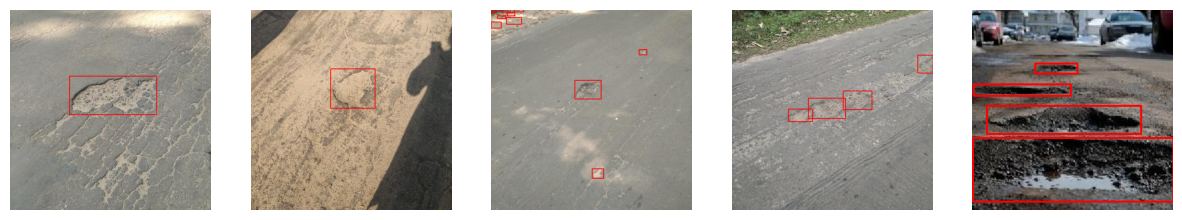

In [66]:
# Sample usage
# Select a few sample images to display
sample_image_filenames = ["img-1.jpg", "img-10.jpg", "img-184.jpg", "img-200.jpg", "img-300.jpg"]  # Add image names as needed
display_images_with_boxes(sample_image_filenames, ground_truth_boxes, data_dir)

## Extract object proposals for all the images

In [30]:
# Directory path for images
data_dir = "02516_poster_3/Potholes/annotated-images"

# Parameters
resize_dim = (200, 200)  # Resize dimension for efficiency
proposal_limit = 100  # Limit number of proposals if needed

# Dictionary to store all proposals
all_proposals = {}

def selective_search_proposals(image, limit=None):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    return rects[:limit] if limit else rects

def resize_image(image, dim):
    return cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

def generate_proposals(data_dir, resize_dim=(400, 400), proposal_limit=200):
    total_images = 665  # Total number of images in the dataset
    for i in range(1, total_images + 1):
        image_file = f"img-{i}.jpg"
        print(f"Processing {image_file} ({i}/{total_images})")
        image_path = os.path.join(data_dir, image_file)
        
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            resized_image = resize_image(image, resize_dim)
            proposals = selective_search_proposals(resized_image, limit=proposal_limit)
            
            # Save proposals in the dictionary
            all_proposals[image_file] = [{"x": x, "y": y, "width": w, "height": h} for (x, y, w, h) in proposals]
        else:
            print(f"Image file {image_file} not found.")

def plot_image_with_proposals(image_file, proposals, data_dir, resize_dim=(400, 400)):
    """
    Plot an image with its proposals drawn as bounding boxes.
    """
    # Load and resize image
    image_path = os.path.join(data_dir, image_file)
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, resize_dim, interpolation=cv2.INTER_AREA)
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    
    # Draw each proposal as a rectangle
    for proposal in proposals:
        x, y, w, h = proposal["x"], proposal["y"], proposal["width"], proposal["height"]
        cv2.rectangle(resized_image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    # Plot the image with proposals
    plt.figure(figsize=(6, 6))
    plt.imshow(resized_image)
    plt.axis("off")
    plt.title(f"Proposals for {image_file}")
    plt.show()


In [31]:
# Generate proposals and store them in the dictionary
generate_proposals(data_dir, resize_dim, proposal_limit)

Processing img-1.jpg (1/665)
Processing img-2.jpg (2/665)
Processing img-3.jpg (3/665)
Processing img-4.jpg (4/665)
Processing img-5.jpg (5/665)
Processing img-6.jpg (6/665)
Processing img-7.jpg (7/665)
Processing img-8.jpg (8/665)
Processing img-9.jpg (9/665)
Processing img-10.jpg (10/665)
Processing img-11.jpg (11/665)
Processing img-12.jpg (12/665)
Processing img-13.jpg (13/665)
Processing img-14.jpg (14/665)
Processing img-15.jpg (15/665)
Processing img-16.jpg (16/665)
Processing img-17.jpg (17/665)
Processing img-18.jpg (18/665)
Processing img-19.jpg (19/665)
Processing img-20.jpg (20/665)
Processing img-21.jpg (21/665)
Processing img-22.jpg (22/665)
Processing img-23.jpg (23/665)
Processing img-24.jpg (24/665)
Processing img-25.jpg (25/665)
Processing img-26.jpg (26/665)
Processing img-27.jpg (27/665)
Processing img-28.jpg (28/665)
Processing img-29.jpg (29/665)
Processing img-30.jpg (30/665)
Processing img-31.jpg (31/665)
Processing img-32.jpg (32/665)
Processing img-33.jpg (33/

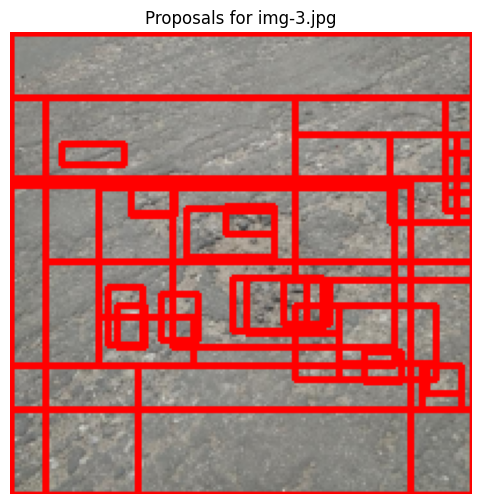

In [50]:
# Choose a random image from the proposals
random_image_file = 'img-3.jpg' # random.choice(list(all_proposals.keys()))
plot_image_with_proposals(random_image_file, all_proposals[random_image_file], data_dir, resize_dim)


## Evaluate the proposals - recall

In [47]:
import json

def calculate_iou(boxA, boxB):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.
    """
    xA = max(boxA["x"], boxB["x"])
    yA = max(boxA["y"], boxB["y"])
    xB = min(boxA["x"] + boxA["width"], boxB["x"] + boxB["width"])
    yB = min(boxA["y"] + boxA["height"], boxB["y"] + boxB["height"])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both boxes
    boxAArea = boxA["width"] * boxA["height"]
    boxBArea = boxB["width"] * boxB["height"]

    # Compute IoU
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [62]:
def evaluate_proposals(all_proposals, ground_truth_boxes, iou_threshold=0.5):
    """
    Evaluate proposals on the training set and calculate recall.
    """
    proposals_per_image = [20, 50, 80, 100]  # Adjusted proposal limits for datasets with fewer proposals per image
    results = {}

    for max_proposals in proposals_per_image:
        total_recall = 0
        
        # Evaluate recall across all images for this proposal limit
        for image_file, proposals in all_proposals.items():
            gt_boxes = ground_truth_boxes.get(image_file, [])
            matched_boxes = set()
            
            # Use only the available proposals if fewer than `max_proposals`
            limited_proposals = proposals[:max_proposals] if len(proposals) > max_proposals else proposals

            # Check each ground truth box for matches in proposals
            for gt in gt_boxes:
                for proposal in limited_proposals:
                    if calculate_iou(gt, proposal) >= iou_threshold:
                        matched_boxes.add(tuple(gt.items()))  # Track matched ground truth boxes
                        break  # Move to the next ground truth box if matched
            
            # Calculate recall for this image
            recall = len(matched_boxes) / len(gt_boxes) if gt_boxes else 0
            total_recall += recall

        # Calculate average recall across all images
        average_recall = total_recall / len(all_proposals) if all_proposals else 0
        results[max_proposals] = average_recall
        print(f"Max Proposals per Image: {max_proposals} - Average Recall: {average_recall:.2f}")

    return results

def show_matched_proposals(all_proposals, ground_truth_boxes, data_dir, iou_threshold=0.5, max_images=5):
    """
    Display images with proposals that have an IoU over the threshold with ground truth boxes, in a single row.
    """
    images_shown = 0  # Track the number of images displayed
    plt.figure(figsize=(15, 5))  # Set up figure for multiple images in a row
    
    for image_file, proposals in all_proposals.items():
        if images_shown >= max_images:
            break
        
        gt_boxes = ground_truth_boxes.get(image_file, [])
        matched_proposals = []

        # Identify matched proposals based on IoU
        for gt in gt_boxes:
            for proposal in proposals:
                if calculate_iou(gt, proposal) >= iou_threshold:
                    matched_proposals.append((gt, proposal))
                    break  # Only need one matching proposal per ground truth box

        # Skip if no matches are found
        if not matched_proposals:
            continue
        
        # Load and process the image
        image_path = os.path.join(data_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Draw ground-truth boxes in green and proposals in red
        for gt, proposal in matched_proposals:
            # Draw ground-truth box (green)
            x, y, width, height = gt["x"], gt["y"], gt["width"], gt["height"]
            cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)
            
            # Draw proposal box (red)
            px, py, pwidth, pheight = proposal["x"], proposal["y"], proposal["width"], proposal["height"]
            cv2.rectangle(image, (px, py), (px + pwidth, py + pheight), (255, 0, 0), 2)
        
        # Plot image in a subplot
        plt.subplot(1, max_images, images_shown + 1)
        plt.imshow(image)
        plt.title(f"{image_file} (IoU > {iou_threshold})")
        plt.axis("off")
        
        images_shown += 1  # Increment displayed images counter
    
    plt.tight_layout()
    plt.show()




Max Proposals per Image: 20 - Average Recall: 0.01
Max Proposals per Image: 50 - Average Recall: 0.01
Max Proposals per Image: 80 - Average Recall: 0.02
Max Proposals per Image: 100 - Average Recall: 0.02


**We choose 80 proposals per image**

Max Proposals per Image: 20 - Average Recall: 0.01
Max Proposals per Image: 50 - Average Recall: 0.01
Max Proposals per Image: 80 - Average Recall: 0.02
Max Proposals per Image: 100 - Average Recall: 0.02


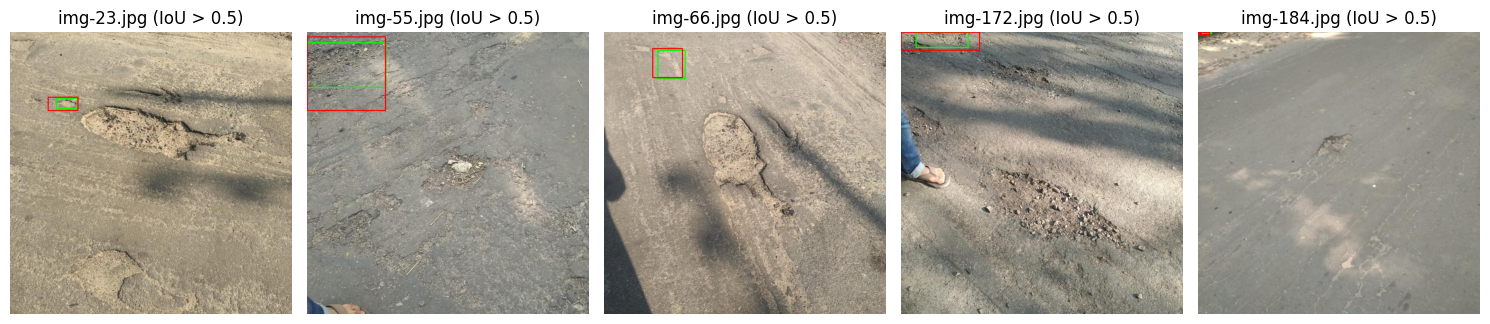

In [68]:
# Run the evaluation with specified maximum proposals per image
optimal_proposal_counts = evaluate_proposals(all_proposals, ground_truth_boxes)

# Example usage
show_matched_proposals(all_proposals, ground_truth_boxes, data_dir, iou_threshold=0.5, max_images=5)


## Assign a label to the proposals

In [69]:
def prepare_proposals_for_training(all_proposals, ground_truth_boxes, iou_threshold=0.5):
    """
    Prepare proposals for training by assigning a class label or background label to each proposal.
    """
    labeled_proposals = {}  # Dictionary to store labeled proposals for each image

    for image_file, proposals in all_proposals.items():
        gt_boxes = ground_truth_boxes.get(image_file, [])
        image_labeled_proposals = []

        for proposal in proposals[:80]:  # Limit to 80 proposals per image
            label = "background"  # Default label
            for gt in gt_boxes:
                if calculate_iou(gt, proposal) >= iou_threshold:
                    label = "pothole"  # Change label if IoU threshold is met
                    break  # Only need one ground truth match to label as pothole

            # Add labeled proposal to the list
            image_labeled_proposals.append({
                "x": proposal["x"],
                "y": proposal["y"],
                "width": proposal["width"],
                "height": proposal["height"],
                "label": label
            })

        # Store labeled proposals for this image
        labeled_proposals[image_file] = image_labeled_proposals

    return labeled_proposals

# Example usage
labeled_proposals = prepare_proposals_for_training(all_proposals, ground_truth_boxes)
print("Sample labeled proposals:", list(labeled_proposals.items())[:2])  # Display sample output


Sample labeled proposals: [('img-1.jpg', [{'x': 74, 'y': 143, 'width': 38, 'height': 37, 'label': 'background'}, {'x': 0, 'y': 71, 'width': 46, 'height': 33, 'label': 'background'}, {'x': 0, 'y': 0, 'width': 200, 'height': 200, 'label': 'background'}, {'x': 0, 'y': 0, 'width': 200, 'height': 29, 'label': 'background'}, {'x': 115, 'y': 15, 'width': 61, 'height': 3, 'label': 'background'}, {'x': 59, 'y': 67, 'width': 93, 'height': 63, 'label': 'background'}, {'x': 125, 'y': 84, 'width': 75, 'height': 116, 'label': 'background'}, {'x': 36, 'y': 83, 'width': 29, 'height': 45, 'label': 'background'}, {'x': 115, 'y': 12, 'width': 75, 'height': 11, 'label': 'background'}, {'x': 175, 'y': 24, 'width': 15, 'height': 15, 'label': 'background'}, {'x': 0, 'y': 21, 'width': 120, 'height': 112, 'label': 'background'}, {'x': 148, 'y': 125, 'width': 17, 'height': 24, 'label': 'background'}, {'x': 59, 'y': 67, 'width': 56, 'height': 36, 'label': 'background'}, {'x': 57, 'y': 120, 'width': 38, 'height':

In [71]:
def save_proposals_to_json(labeled_proposals, output_file="labeled_proposals.json"):
    """
    Save labeled proposals to a JSON file, ensuring all values are JSON-serializable.
    """
    # Convert all values to Python's native int type
    serializable_proposals = {}
    for image_file, proposals in labeled_proposals.items():
        serializable_proposals[image_file] = [
            {
                "x": int(proposal["x"]),
                "y": int(proposal["y"]),
                "width": int(proposal["width"]),
                "height": int(proposal["height"]),
                "label": proposal["label"]
            }
            for proposal in proposals
        ]
    
    # Save to JSON
    with open(output_file, "w") as f:
        json.dump(serializable_proposals, f, indent=4)
    print(f"Labeled proposals saved to {output_file}")

# Save the labeled proposals
save_proposals_to_json(labeled_proposals)


Labeled proposals saved to labeled_proposals.json
